### Setting the Scene

Imagine you are working for a social media company. The company is concerned with the growing amount of fake news circulatng on it's platform. They have assigned you to investigate how fake news can be recognized and create a method of identifying it. Let's work through this problem together, first by exploring and cleaning the data and then working to classify fake vs factual news stories. We'll also create some plots of our outputs and discuss how we would communicate our findings to stakeholders.

### Import the Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

Plot Styling:

Bigger figure size (12x8 inches)

Custom color #00bfbf (teal shade—nice choice btw)

In [19]:
plt.rcParams['figure.figsize'] = (10, 6)
default_plot_colour = "#00bfbf"

In [11]:
data = pd.read_csv("fake_news_data.csv")
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


“Started my project by importing and exploring the dataset. I ensured a visually clean plotting style and set up for a smooth analysis flow ahead.”

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


In [15]:
data.describe()

,title,text,date,fake_or_factual
count,198,198,198,198
unique,198,198,179,2
top,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"September 7, 2017",Factual News
freq,1,1,3,100


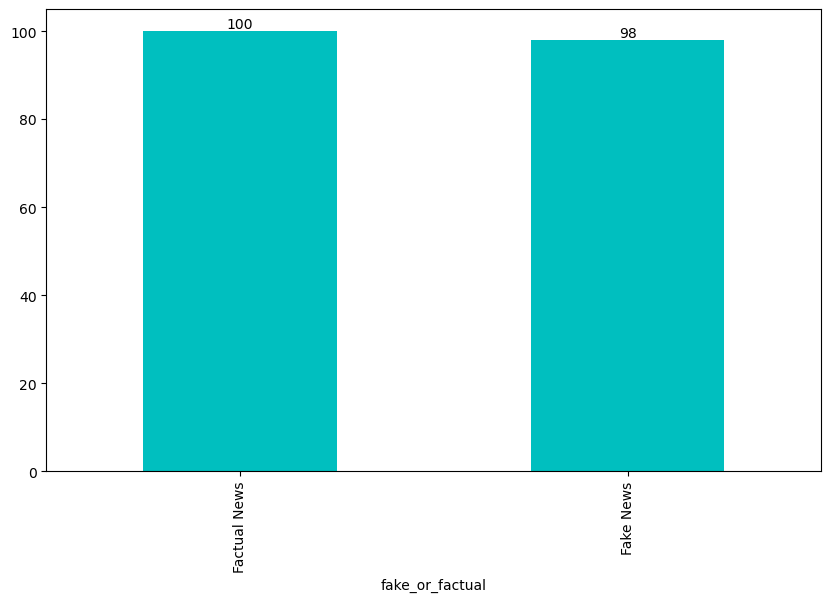

In [21]:
vis = data['fake_or_factual'].value_counts().plot(kind='bar',color=default_plot_colour)
for container in vis.containers:
    vis.bar_label(container)

“Explored the dataset and quickly noticed the distribution of Fake vs Factual news using visualizations. Added clean, professional charts to ensure stakeholders can grasp key insights instantly.”

### Import package required for processing and analysis

In [25]:
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

“For robustness, I imported a mix of traditional NLP libraries like NLTK and SpaCy, combined with advanced classification algorithms to ensure accuracy and explainability in results.”

### POS Tagging

In [28]:
nlp = spacy.load("en_core_web_sm")

In [35]:
fake_news = data[data['fake_or_factual']=="Fake News"]
fact_news = data[data['fake_or_factual']=="Factual News"]

Uses .pipe() for fast batch processing (efficient way in SpaCy).

In [37]:
# create spacey documents - use pipe for dataframe
fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fact_spaceydocs = list(nlp.pipe(fact_news['text'])) 

doc → A processed document (news article) from SpaCy.

For every token (word) in the document:

`i.text` → The actual word.

`i.ent_type_` → Named Entity tag (like PERSON, ORG), empty string if not an entity.

`i.pos_` → Part of Speech tag (NOUN, VERB, ADJ, etc.).

Returns → A list of tuples:
* [(word, entity_tag, POS_tag), …]

In [42]:
# create function to extract tags for each document in our data
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

Step-by-step breakdown for below code:
* You created an empty list called `fake_tagsdf` → this will store the tags from all fake news articles.
* You set columns = ["token", "ner_tag", "pos_tag"] → these will be the column names in your DataFrame.

`enumerate()` is a Python function that:

Gives you both:
* the index (position) of each item (starts from 0)
* and the item itself (like your article/doc).

Loop Part:
* For each fake news article (doc) in fake_spaceydocs:
* extract_token_tags(doc) extracts the word, entity tag, POS tag for that article.
* Converts it into a DataFrame (tags), assigns column names.
* Appends this DataFrame to your list.

Final Step:

pd.concat(fake_tagsdf) combines all article-level DataFrames into one big DataFrame → fake_tagsdf now contains:

Every token from all fake news articles, with its NER and POS tags.

In [50]:
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for ix, doc in enumerate(fake_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns=columns
    fake_tagsdf.append(tags)
fake_tagsdf = pd.concat(fake_tagsdf)   

# tag factual dataset 
fact_tagsdf = []

for ix, doc in enumerate(fact_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)
        
fact_tagsdf = pd.concat(fact_tagsdf)  

In [56]:
print(fake_tagsdf.head())
print("------------------------------")
print(fact_tagsdf.head())

      token   ner_tag pos_tag
0     There              PRON
1       are              VERB
2       two  CARDINAL     NUM
3     small               ADJ
4  problems              NOUN
------------------------------
        token ner_tag pos_tag
0  WASHINGTON     GPE   PROPN
1           (           PUNCT
2     Reuters     ORG   PROPN
3           )           PUNCT
4           -           PUNCT


In [62]:
# token_frequency_count(fake)
pos_counts_fake=fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
pos_counts_fake.head()

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875


In [64]:
# token frequency count(fact)
pos_counts_fact=fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
pos_counts_fact.head()

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789


In [78]:
# frequencies of pos tags(fake)
fk=pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False)
fk.head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

<Axes: xlabel='pos_tag'>

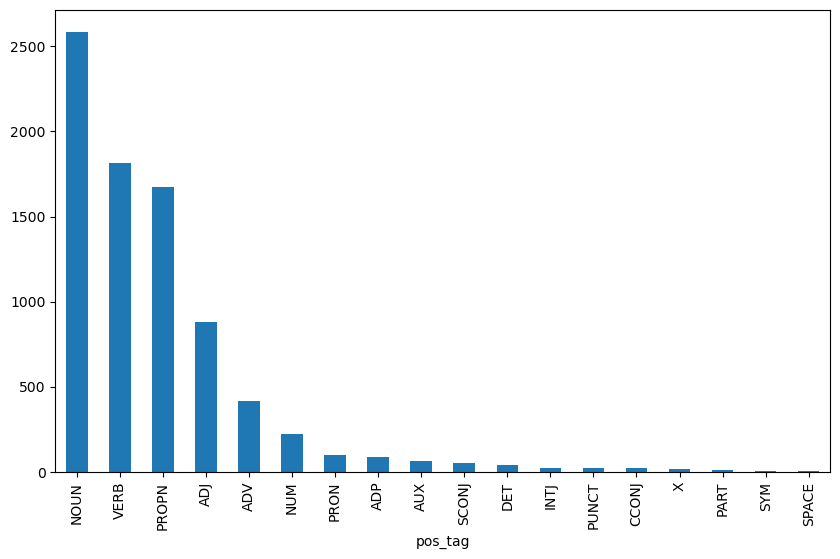

In [80]:
fk.plot(kind="bar")

In [82]:
# frequencies of pos tags(fact)
ft=pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False)
ft.head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

<Axes: xlabel='pos_tag'>

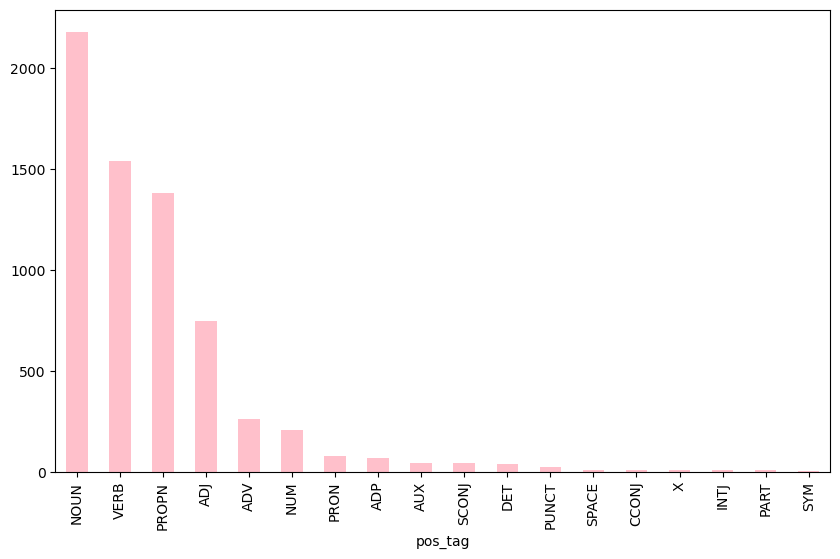

In [84]:
ft.plot(kind="bar", color="pink")

We can observe in above graphs:

Both in fake and factual news, unique number of noun pos tag is more, second is verb and third is proposition

#### NOUNS

In [87]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:10]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [91]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][0:10]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


#### Adjectives

In [94]:
pos_counts_fake[pos_counts_fake.pos_tag == "ADJ"][0:10]

,token,pos_tag,counts
5585,more,ADJ,52
5852,other,ADJ,49
5439,many,ADJ,43
31,-,ADJ,36
6121,political,ADJ,34
1902,Republican,ADJ,32
4434,former,ADJ,31
4299,federal,ADJ,29
415,American,ADJ,28
6780,same,ADJ,27


In [96]:
pos_counts_fact[pos_counts_fact.pos_tag == "ADJ"][0:10]

,token,pos_tag,counts
3631,former,ADJ,50
4796,other,ADJ,49
4560,more,ADJ,44
4504,military,ADJ,43
5005,political,ADJ,43
4248,last,ADJ,38
5068,presidential,ADJ,34
4646,new,ADJ,33
1462,Republican,ADJ,30
3568,first,ADJ,28


#### VERB

In [100]:
pos_counts_fake[pos_counts_fake.pos_tag == "VERB"][0:10]

,token,pos_tag,counts
6763,s,VERB,147
6774,said,VERB,144
4703,have,VERB,76
5171,know,VERB,54
7534,told,VERB,49
5394,made,VERB,45
4645,had,VERB,43
4565,going,VERB,40
4562,go,VERB,40
6797,say,VERB,34


In [102]:
pos_counts_fact[pos_counts_fact.pos_tag=="VERB"][0:10]

,token,pos_tag,counts
5567,said,VERB,451
6210,told,VERB,55
3841,have,VERB,43
6649,’s,VERB,35
4021,including,VERB,33
4410,make,VERB,31
4395,made,VERB,29
6072,take,VERB,28
3168,do,VERB,25
5582,saying,VERB,24


“I went a step further by performing linguistic analysis using POS tagging and named entity recognition. This helped me uncover hidden language patterns often present in fake news articles.”

### Named Entities

In [114]:
# top entities in fake news
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag']!=''].groupby(['token','ner_tag']).size().reset_index(name="counts")\
                    .sort_values(by="counts", ascending=False)

In [174]:
# top entities in fact news
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag']!=''].groupby(['token','ner_tag']).size().reset_index(name="counts")\
                    .sort_values(by="counts", ascending=False)

In [118]:
# create custom palette to ensure plots are consistent
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

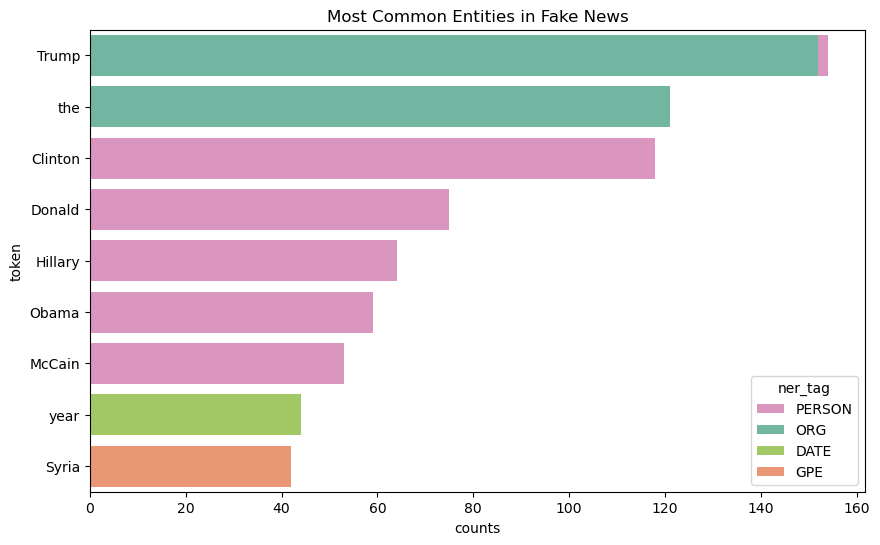

In [130]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Fake News')

Most common entity in fake news trump which was considered as OrG and its frequency is around 140 means its repeated 140 
times in our dataset

since pink represent person, most frequent named entity token is "person" in fake news

[Text(0.5, 1.0, 'Most Common Entities in Fact News')]

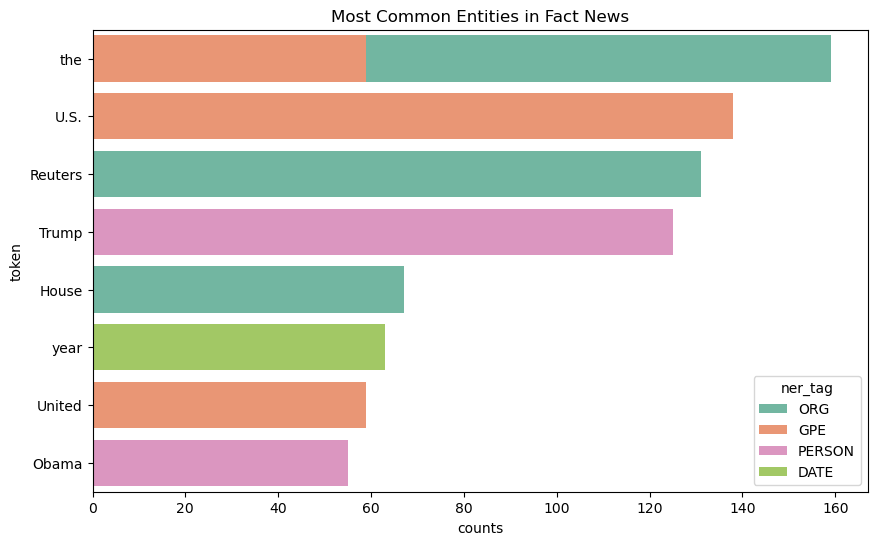

In [140]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fact News')

In the above graph itcan be observed that US country is repeated second most time with frequency around 130 times

As compared to fake in factural person entity is not repeated much, instead it inclueds more about organisation and location with person

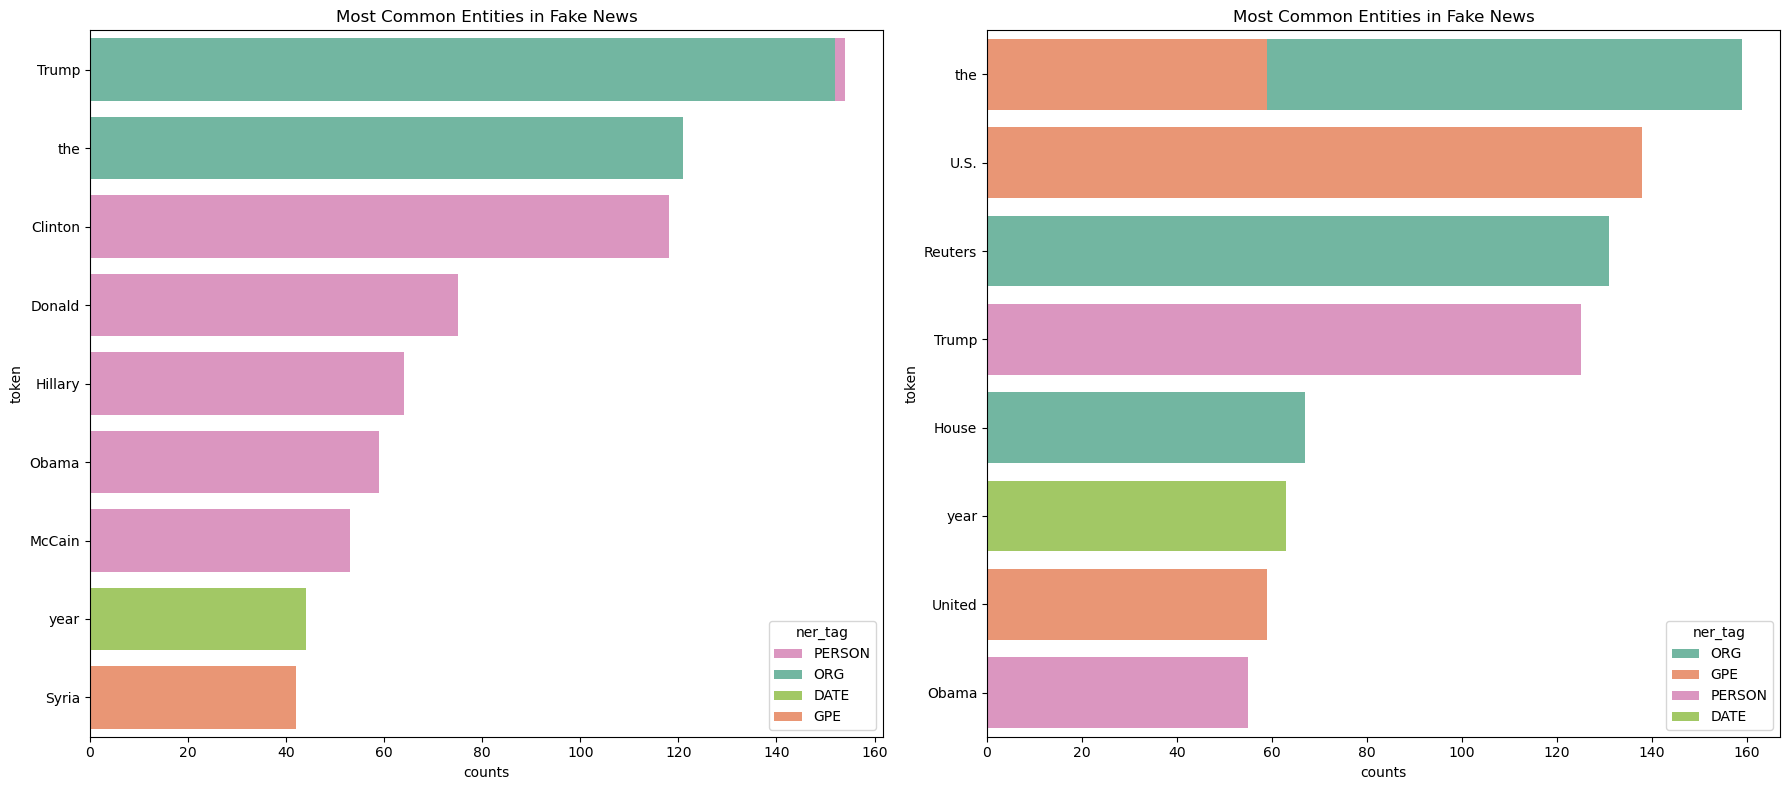

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    ax=axes[0],
    dodge=False
).set(title='Most Common Entities in Fake News')
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    ax=axes[1],
    dodge=False
).set(title='Most Common Entities in Fake News')
plt.tight_layout()
plt.show()

The above graph gives comparision of named entites in both fake and factual which gives the difference between them

fake news is more about person we can anlyse, but factual has more frequency count in all entites

### Text preprocessing

In [145]:
# a lot of the factual news has a location tag at the beginning of the article, let's use regex to remove this
data['text_clean'] = data['text'].apply(lambda x: re.sub(r"^[^-]*-\s*", "", x))

# lowercase 
data['text_clean'] = data['text_clean'].str.lower()

# remove punctuation
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub(r"([^\w\s])", "", x))

# stop words
en_stopwords = stopwords.words('english')
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

# tokenize 
data['text_clean'] = data['text_clean'].apply(lambda x: word_tokenize(x))

#lemmatize
lm=WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda x: [lm.lemmatize(token) for token in x])

In [147]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [149]:
# most common unigrams after preprocessing
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


C:\Users\Shrusti YR\AppData\Local\Temp\ipykernel_11632\4019870307.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

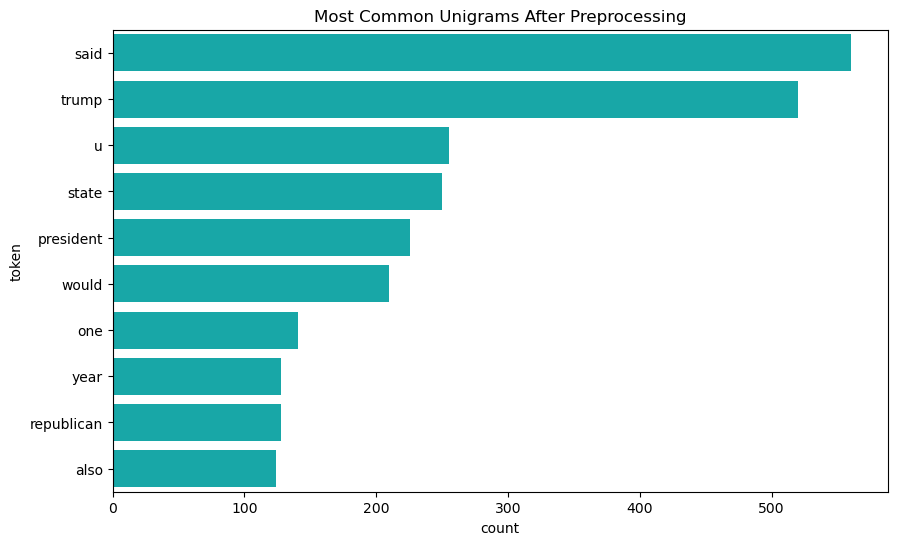

In [151]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count", 
            y = "token", 
            data=unigrams,
            orient = 'h',
            palette=[default_plot_colour],
            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

In [153]:
# most common bigrams after preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()) 
print(bigrams[:10])

(donald, trump)        92
(united, state)        80
(white, house)         72
(president, donald)    42
(hillary, clinton)     31
(new, york)            31
(image, via)           29
(supreme, court)       29
(official, said)       26
(food, stamp)          24
Name: count, dtype: int64


### Sentiment Analysis

In [156]:
# use vader so we also get a neutral sentiment count
vader_sentiment = SentimentIntensityAnalyzer()

data['vader_sentiment_score'] = data['text'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

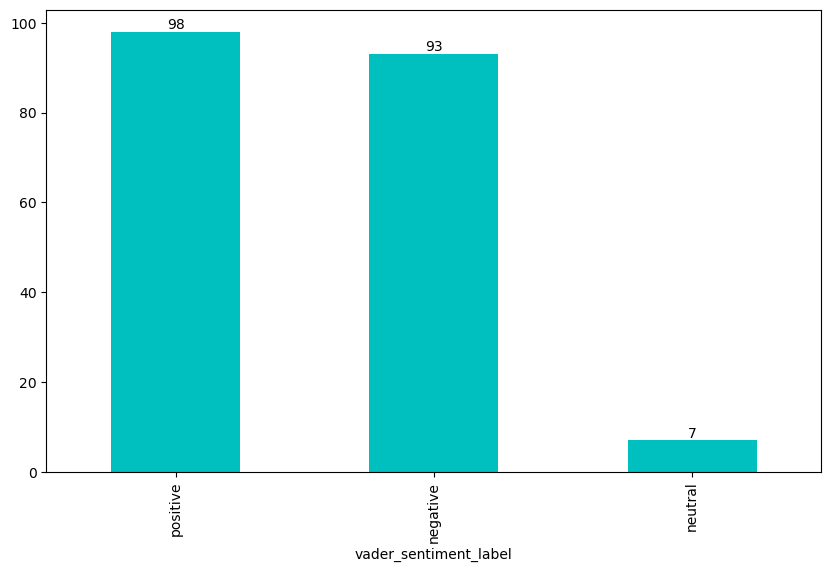

In [158]:
vis=data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)
for container in vis.containers:
    vis.bar_label(container)

C:\Users\Shrusti YR\AppData\Local\Temp\ipykernel_11632\1817320464.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


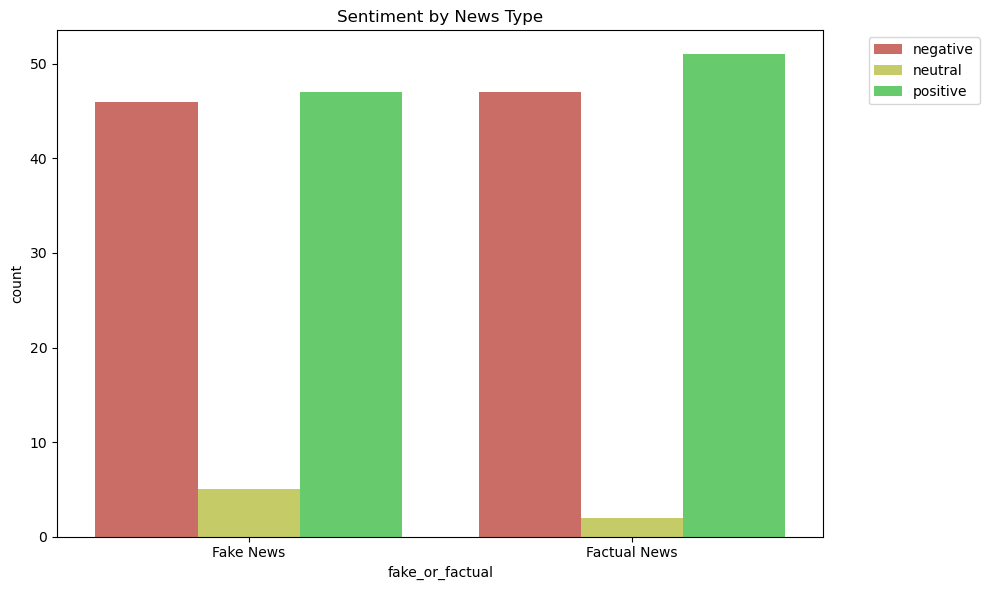

In [162]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
).set(title='Sentiment by News Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

The above graphs compares the sentimental analysis of bothe fake and factual news

factual news have more positie sentiment comparitively

fake news have more neutral sentiment comparitively

### Latent Dirichlet Allocation

In [168]:
# fake news data vectorization
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

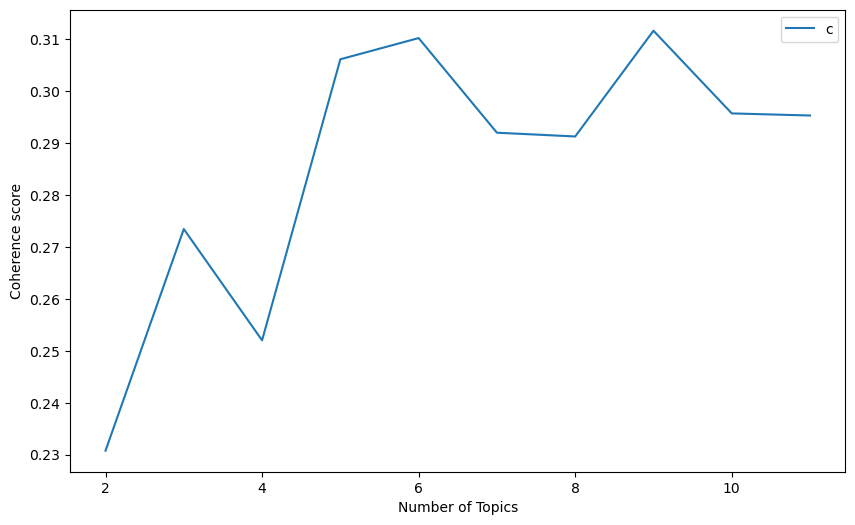

In [176]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake, random_state=42, passes=10) # fixed seed
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


The representation of coherent graph for LDA algorithm shows more coherent value at 6 number of topics which wil be optimal


In [179]:
# create lda model
num_topics_fake = 6 

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.013*"trump" + 0.005*"said" + 0.004*"clinton" + 0.004*"state" + 0.003*"woman" + 0.003*"one" + 0.003*"president" + 0.003*"republican" + 0.003*"also" + 0.003*"law"'),
 (1,
  '0.009*"trump" + 0.005*"said" + 0.005*"clinton" + 0.004*"time" + 0.004*"woman" + 0.003*"state" + 0.003*"mccain" + 0.003*"u" + 0.003*"obama" + 0.003*"would"'),
 (2,
  '0.005*"would" + 0.005*"mccain" + 0.004*"said" + 0.004*"trump" + 0.004*"president" + 0.004*"one" + 0.004*"year" + 0.003*"state" + 0.003*"people" + 0.003*"syria"'),
 (3,
  '0.011*"trump" + 0.006*"said" + 0.005*"state" + 0.005*"would" + 0.005*"clinton" + 0.004*"woman" + 0.004*"one" + 0.004*"president" + 0.003*"u" + 0.003*"republican"'),
 (4,
  '0.019*"trump" + 0.005*"u" + 0.004*"president" + 0.004*"republican" + 0.004*"image" + 0.003*"clinton" + 0.003*"student" + 0.003*"one" + 0.003*"people" + 0.003*"said"'),
 (5,
  '0.007*"trump" + 0.005*"said" + 0.005*"president" + 0.004*"clinton" + 0.004*"time" + 0.003*"republican" + 0.003*"party" + 0.003*"also

### TF-IDF & LSA

In [181]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [185]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(["Coherence Score"], loc='best')
    plt.tight_layout()
    plt.show()

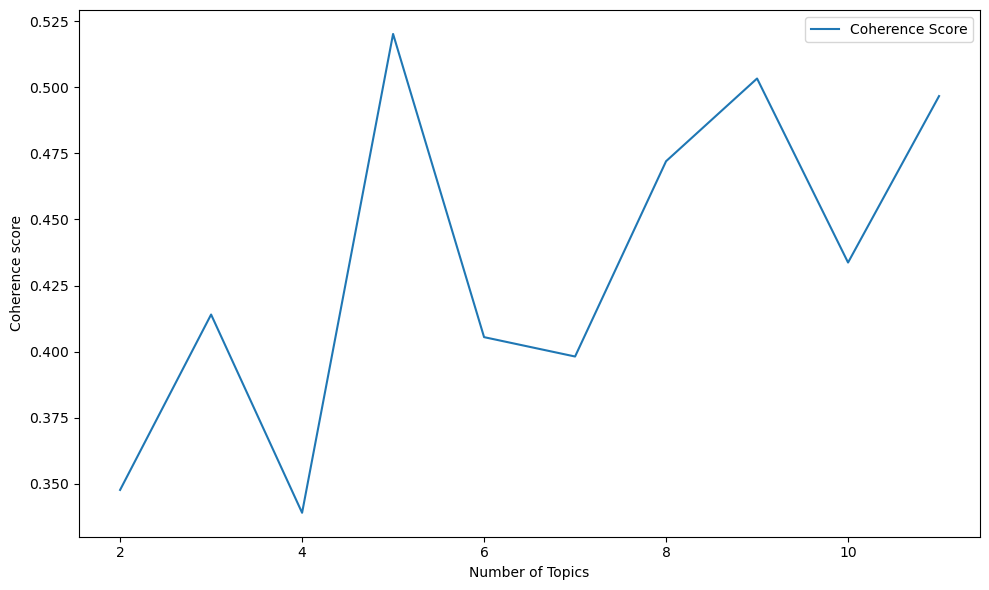

In [187]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

The representation of coherent graph for LDA model shows more coherent value at 6 number of topics which wil be optimal

In [190]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '0.299*"boiler" + 0.253*"room" + 0.250*"acr" + 0.186*"jay" + 0.185*"animal" + 0.176*"episode" + 0.147*"analysis" + 0.122*"dyer" + 0.119*"savant" + 0.119*"moralist"'),
 (2,
  '0.219*"school" + -0.195*"clinton" + -0.163*"conference" + 0.151*"county" + 0.137*"student" + -0.120*"press" + -0.116*"trump" + -0.112*"hillary" + 0.101*"love" + -0.095*"email"'),
 (3,
  '-0.375*"flynn" + -0.151*"russian" + -0.111*"email" + -0.109*"30" + -0.101*"department" + -0.100*"information" + -0.100*"nana" + -0.099*"official" + -0.098*"mccain" + 0.096*"trump"'),
 (4,
  '0.235*"trump" + 0.223*"flynn" + 0.166*"conference" + -0.165*"clinton" + -0.153*"dnc" + -0.151*"sander" + -0.127*"email" + 0.111*"press" + -0.109*"rich" + 0.084*"tax"')]

### Predict fake or factual news

In [192]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [196]:
X = [','.join(map(str, l)) for l in data['text_clean']] #map(str, l) → applies the str() function to every element in the list.
#It converts all elements into strings before joining.
Y = data['fake_or_factual']

In [198]:
# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [200]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

#### Logistic Regression

In [202]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [204]:
y_pred_lr = lr.predict(X_test)

In [206]:
accuracy_score(y_pred_lr, y_test)

0.9

In [208]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.94      0.88      0.91        34
   Fake News       0.86      0.92      0.89        26

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



#### Naive Bayes

In [213]:
from sklearn.naive_bayes import MultinomialNB

In [218]:
nb = MultinomialNB().fit(X_train, y_train)

In [220]:
y_pred_nb = nb.predict(X_test)

In [222]:
accuracy_score(y_pred_nb, y_test)

0.9166666666666666

In [224]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

Factual News       0.91      0.94      0.93        34
   Fake News       0.92      0.88      0.90        26

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60



#### Linear support vector machine

In [227]:
svm = SGDClassifier().fit(X_train, y_train)

In [229]:
y_pred_svm = svm.predict(X_test)

In [231]:
accuracy_score(y_pred_svm, y_test)

0.9166666666666666

In [233]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.89      0.97      0.93        34
   Fake News       0.96      0.85      0.90        26

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60



### Conclusion

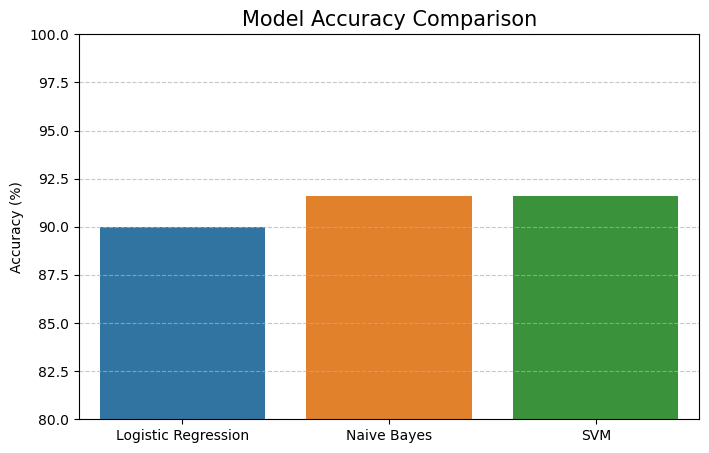

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ['Logistic Regression', 'Naive Bayes', 'SVM']
accuracies = [90, 91.6, 91.6]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=accuracies, hue=model_names, legend=False)
plt.title('Model Accuracy Comparison', fontsize=15)
plt.ylabel('Accuracy (%)')
plt.ylim(80, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Final Model Comparison Bar Graph

Tested 3 models:
* Logistic Regression → 90% accuracy
* Naive Bayes → 91.6% accuracy
* SVM (SGD Classifier) → 91.6% accuracy

Naive Bayes and SVM gave the best results with 91.6% accuracy, showing how simple models can still be highly effective in NLP.